Let's start by importing all the crap we're gonna need for this venture.

In [1]:
import pickle
import requests
import bs4
from bs4 import BeautifulSoup as bs
import pandas as pd
import string
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as rp
%matplotlib inline

Now let's pull out the pickled files that we've delicately scraped from the internet. The insides of that sausage are not fit for public consumption.

In [128]:
with open('top_movies.pkl', 'r') as f:
    top_movies = pickle.load(f)
with open('actor_and_old_movie_cache_full.pkl', 'r') as g:
    (actors, old_movies) = pickle.load(g)
with open('heres_where_i_scrape_actor_count_from.pkl', 'r') as h:
    pages = pickle.load(h)
with open('counts.pkl', 'r') as i:
    counts = pickle.load(i)

And after a little data cleaning/spot testing ...

In [3]:
pages = pages[:225] + pages[226:239]
soups = [bs(page) for page in pages]

In [24]:
actor_frame = pd.DataFrame.from_dict(actors, 'index')
actor_frame.columns = ['name', 'film_grosses']
actor_frame['sum_grosses'] = actor_frame['film_grosses'].apply(lambda x: np.sum(x) if len(x) > 0 else 0)
actor_frame['num_movies'] = actor_frame['film_grosses'].apply(len)
actor_frame['mean_grosses'] = actor_frame['film_grosses'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
actor_frame['std_grosses'] = actor_frame['film_grosses'].apply(lambda x: np.std(x) if len(x) > 0 else 0)
actor_frame[actor_frame.name == "Mark Wahlberg"]

,name,film_grosses,sum_grosses,num_movies,mean_grosses,std_grosses
/name/nm0000242/,Mark Wahlberg,"[93617009, 119219978, 98711404, 43818839, 4068...",1481810771,26,56992721.961538,51609796.040148


... we have a good database to draw from!

Quick explanations here:

actor_frame contains a list of actors (indexed by IMDB link suffix), along with a list of the historical grosses of movies they were in in or prior to 2010 and a few statistics on that list.

top_movies contains a list of the 238 movies we are considering for our prediction model, along with their total domestic gross, year, and IMDB link suffix. These movies were the pulled from the list of highest-grossing summer films from 2011-2015. 

Now for a simple helper function that takes as input the HTML text of a movie page and returns a list of links to the actor pages for the actors in that movie:

In [5]:
def get_actor_info_by_movie(soup):
    actor_list = []
    for row in soup.find('table', class_='cast_list').children:
        if type(row) == bs4.element.Tag:
            is_actor = row.find('td', itemprop='actor')
            if is_actor:
                link = is_actor.find('a').get('href')
                link = link[:link.find('?')]
                actor_list.append(link)
    return actor_list

We will assign different statistics to each movie that will (hopefully!) reflect the popularity and previous success of the actors therein. 

A quick overview:

- First, we take the logarithm of the total domestic gross (the value we are predicting), in order to give it a more normal looking distribution (see graphs below).

- The column of 'counts' is a measure of how many "famous actors" are in the movie, where determination of "famous" is based on a list scraped from boxofficemojo.com that ranks the top 100 actors who have appeared in 10 or more films by total average gross over all those films. The range of this variable for our dataset is 0 - 8.

- We will also consider the N actors from each movie in our dataset who have the highest *overall* movie gross, and find the average of their:
    - Number of films in or before 2010.
    - Mean gross per film in or before 2010.
    
Note: Choosing N is a task we want to perform carefully, as different values lead to different models. Since most of the movies I looked at on IMDB have 15 actors listed on the front page, I let N range from 1 to 15 and created fifteen different models.

In [167]:
top_movies['log_gross'] = map(lambda x: math.log(1+x), top_movies.gross)
top_movies['counts'] = counts

all_models = []

def make_model(num_actors):
    total_sum = []
    total_mean = []
    total_num = []
    movies = top_movies.copy(deep = True)
    for soup in soups:
        sums, means, nums = [], [], []
        for link in get_actor_info_by_movie(soup):
            if link in actor_frame.index:
                actor = actor_frame.ix[link]
                sums.append(actor.sum_grosses)
                nums.append(actor.num_movies)
                means.append(actor.mean_grosses)
        df = pd.DataFrame(zip(sums, means, nums), columns = ['sums', 'means', 'nums'])
        df = df.sort(columns = ['sums'], ascending = False)[:num_actors]
        total_num.append(np.mean(df.nums))
        total_sum.append(np.mean(df.sums))
        total_mean.append(np.mean(df.means))

    movies['total_sum'] = total_sum
    movies['total_mean'] = total_mean
    movies['total_num'] = total_num
    return movies

for n in range(1, 16):
    all_models.append(make_model(n))

len(all_models)

15

In [186]:
results = []
models = []
for frame in all_models:
    y, X = dmatrices('log_gross ~ counts+total_num+total_mean', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)

(15, 15)

0.31258120934208333

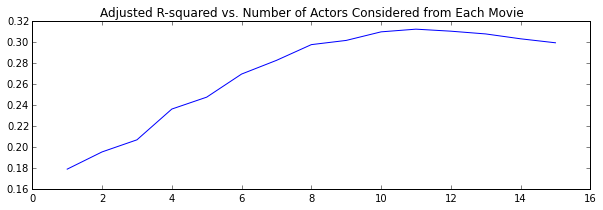

In [187]:
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Number of Actors Considered from Each Movie')
adj_r_sq[10]

So it looks like we would want to consider the 11 top actors in terms of total gross with this approach, i.e. models[10], in order to maximize the adjusted R-squared value.

Let's try a different approach.

Now, we'll take the N actors from each movie in our dataset who have been *in* the most films prior to 2011, and compute the same averaging on their personal statistics to yield the relevant features for the movie.

In [168]:
all_models2 = []

def make_model2(num_actors):
    total_sum = []
    total_mean = []
    total_num = []
    movies = top_movies.copy(deep = True)
    for soup in soups:
        sums, means, nums = [], [], []
        for link in get_actor_info_by_movie(soup):
            if link in actor_frame.index:
                actor = actor_frame.ix[link]
                sums.append(actor.sum_grosses)
                nums.append(actor.num_movies)
                means.append(actor.mean_grosses)
        df = pd.DataFrame(zip(sums, means, nums), columns = ['sums', 'means', 'nums'])
        df = df.sort(columns = ['nums'], ascending = False)[:num_actors]
        total_num.append(np.mean(df.nums))
        total_sum.append(np.mean(df.sums))
        total_mean.append(np.mean(df.means))

    movies['total_sum'] = total_sum
    movies['total_mean'] = total_mean
    movies['total_num'] = total_num
    return movies

for n in range(1, 16):
    all_models2.append(make_model2(n))

len(all_models2)

15

In [150]:
results2 = []
models2 = []
for fr in all_models2:
    y, X = dmatrices('log_gross ~ counts+total_num+total_mean', data=fr, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    m = sm.OLS(y_train, X_train)
    models2.append(m)
    results2.append(m.fit())

len(results2), len(models2)

(15, 15)

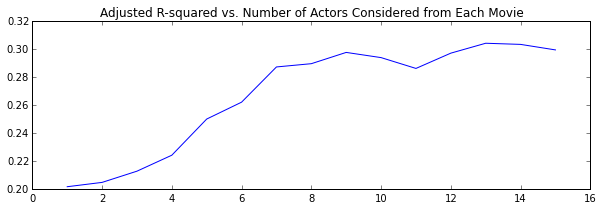

In [151]:
adj_r_sq2 = []

for i in range(len(results2)):
    adj_r_sq2.append(results2[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(range(1, 16), adj_r_sq2)
plt.title('Adjusted R-squared vs. Number of Actors Considered from Each Movie')

In [163]:
print max(adj_r_sq2)

0.304339342953


So it may be better to take the top N actors measured by their total sums of the grosses of their previous movies rather than the number of movies they've been in.

One more approach. I'll choose the N actors who have the highest *mean* gross in films before 2011, and compute features from their statistics:

In [152]:
all_models3 = []

def make_model3(num_actors):
    total_sum = []
    total_mean = []
    total_num = []
    movies = top_movies.copy(deep = True)
    for soup in soups:
        sums, means, nums = [], [], []
        for link in get_actor_info_by_movie(soup):
            if link in actor_frame.index:
                actor = actor_frame.ix[link]
                sums.append(actor.sum_grosses)
                nums.append(actor.num_movies)
                means.append(actor.mean_grosses)
        df = pd.DataFrame(zip(sums, means, nums), columns = ['sums', 'means', 'nums'])
        df = df.sort(columns = ['means'], ascending = False)[:num_actors]
        total_num.append(np.mean(df.nums))
        total_sum.append(np.mean(df.sums))
        total_mean.append(np.mean(df.means))

    movies['total_sum'] = total_sum
    movies['total_mean'] = total_mean
    movies['total_num'] = total_num
    return movies

for n in range(1, 16):
    all_models3.append(make_model3(n))

len(all_models3)

15

In [153]:
results3 = []
models3 = []
for fr in all_models3:
    y, X = dmatrices('log_gross ~ counts+total_num+total_mean', data=fr, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    m = sm.OLS(y_train, X_train)
    models3.append(m)
    results3.append(m.fit())

len(results3), len(models3)

(15, 15)

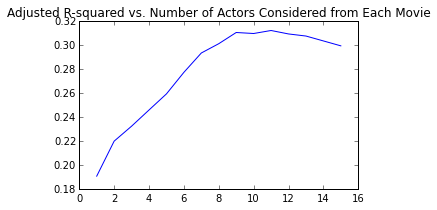

In [155]:
adj_r_sq3 = []

for i in range(len(results3)):
    adj_r_sq3.append(results3[i].rsquared_adj)
plt.figure(figsize = (5, 3))
plt.plot(range(1, 16), adj_r_sq3)
plt.title('Adjusted R-squared vs. Number of Actors Considered from Each Movie')

In [162]:
print max(adj_r_sq3)

0.312393250851


I wonder what it is about 11 actors that makes this so!

We'll stick with measuring the top 11 actors by total historical gross.

In [182]:
k = 10
frame, model, result = all_models[k], models[k], results[k]
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_gross   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     33.28
Date:                Thu, 08 Oct 2015   Prob (F-statistic):           1.21e-17
Time:                        19:51:46   Log-Likelihood:                -288.42
No. Observations:                 214   AIC:                             584.8
Df Residuals:                     210   BIC:                             598.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     16.5193      0.151    109.252      0.000        16.221    16.817
counts         0.1666      0.067      2.470      0.014         0.034     0.300
total_num      0.0309      0.012      2.516      0.013         0.007     0.055
total_mean  1.707e-08   3.21e-09      5.311      0.000      1.07e-08  2.34e-08
==============================================================================
Omnibus:                        3.450   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.457
Skew:                          -0.307   Prob(JB):                        0.178
Kurtosis:                       2.896   Cond. No.                     1.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x173b667d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x174eee5d0>]], dtype=object)

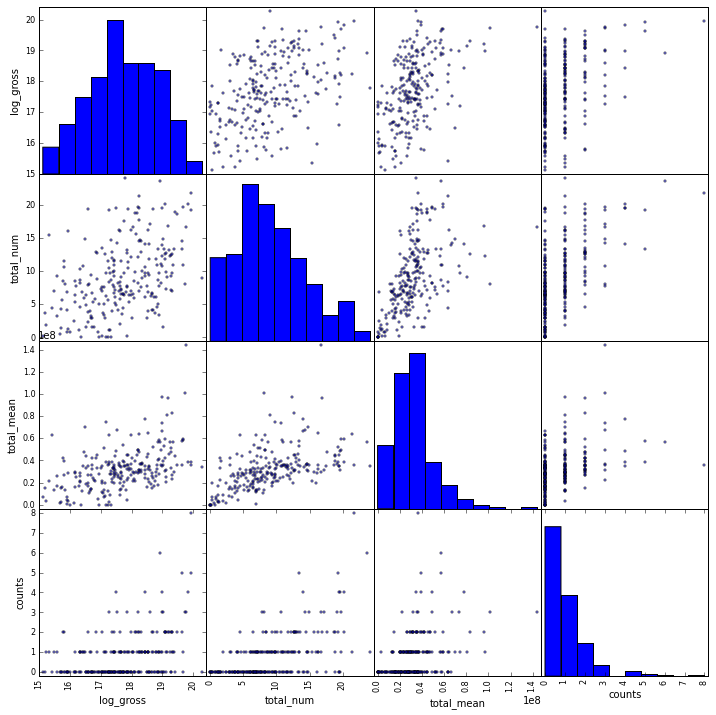

In [233]:
cols = ['log_gross', 'total_num', 'total_mean', 'counts']
pd.scatter_matrix(frame[cols], figsize=(12, 12))

We can see below that the residuals for this model are roughly normal and centered around 0, as we would hope.

(array([  5.,  10.,  18.,  31.,  41.,  43.,  40.,  21.,   4.,   1.]),
 array([-2.49309825, -1.98365858, -1.47421891, -0.96477924, -0.45533957,
         0.05410011,  0.56353978,  1.07297945,  1.58241912,  2.09185879,
         2.60129846]),
 <a list of 10 Patch objects>)

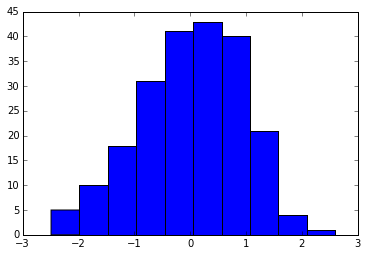

In [166]:
plt.hist(result.resid)

In [251]:
params = list(result.params)
means = [1, np.mean(X_train.counts), np.mean(X_train.total_num), np.mean(X_train.total_mean)]
print params, means

[16.519277829047919, 0.16663872638295341, 0.030891476752591913, 1.7073565010750398e-08] [1, 0.7990654205607477, 9.02044072230988, 31821049.809221182]


In [275]:
def make_trend_line(p):
    features = ['counts', 'total_num', 'total_mean']
    par = params[:p + 1]+params[p + 2:]
    me = means[:p + 1]+means[p + 2:]
    a0 = 0
    for i in range(3):
        a0 += par[i]*me[i]
    xp = np.linspace(0, max(X_train[features[p]]), 10)
    yp = [a0 + params[p+1]*x for x in xp]
    plt.plot(X_train[features[p]], y_train, 'k.', xp, yp, '-')

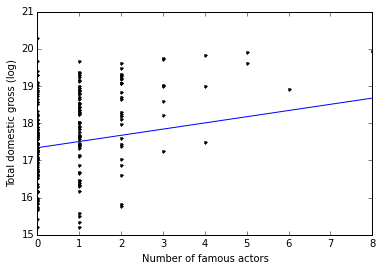

In [279]:
make_trend_line(0)
plt.xlabel("Number of famous actors")
plt.ylabel("Total domestic gross (log)")

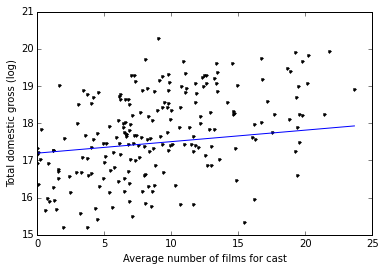

In [280]:
make_trend_line(1)
plt.xlabel("Average number of films for cast")
plt.ylabel("Total domestic gross (log)")

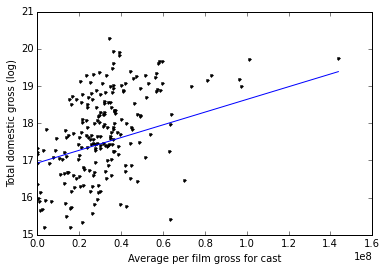

In [281]:
make_trend_line(2)
plt.xlabel("Average per film gross for cast")
plt.ylabel("Total domestic gross (log)")